In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import partial_dependence
from mlp_keras import MLP
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Load data, specify locations

folder = '../report/NO_OS/postop'
file = '/data.csv'

data = pd.read_csv(folder + file)

X, y = data.iloc[:,:-1], data.iloc[:, -1]
feature_names, target_names = data.columns[:-1].to_list(), data.columns[-1:].to_list()

In [3]:
# Split the data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [4]:
# Load and train the model

is_model_nn = True

# # RF
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)
# accuracy_score(y_test, lr.predict(X_test))


# NN
model = MLP(folder + '/data_norm.csv')

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True)
rlr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=0.0000001)

model.train(
    9,
    3,
    'SGD',
    0.01,
    [early_stopping_callback, rlr_callback],
    dropout=0.24,
    save_folder=None,
    oversampling=False,
    test=False
)

Epoch 1/300
28/28 [==============================] - 1s 8ms/step - loss: 1.0226 - accuracy: 0.6441 - val_loss: 0.9179 - val_accuracy: 0.8036 - lr: 0.0100
Epoch 2/300
28/28 [==============================] - 0s 4ms/step - loss: 0.8561 - accuracy: 0.8018 - val_loss: 0.7774 - val_accuracy: 0.8036 - lr: 0.0100
Epoch 3/300
28/28 [==============================] - 0s 6ms/step - loss: 0.7408 - accuracy: 0.8018 - val_loss: 0.6924 - val_accuracy: 0.8036 - lr: 0.0100
Epoch 4/300
28/28 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.8018 - val_loss: 0.6523 - val_accuracy: 0.8036 - lr: 0.0100
Epoch 5/300
28/28 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.8018 - val_loss: 0.6323 - val_accuracy: 0.8036 - lr: 0.0100
Epoch 6/300
28/28 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.8018 - val_loss: 0.6212 - val_accuracy: 0.8036 - lr: 0.0100
Epoch 7/300
28/28 [==============================] - 0s 4ms/step - loss: 0.6

PyALE._ALE_generic:INFO: Continuous feature detected.


22/22 [==============================] - 0s 1ms/step


PyALE._ALE_generic:INFO: Discrete feature detected.


9/9 [==============================] - 0s 1ms/step


PyALE._ALE_generic:INFO: Continuous feature detected.


22/22 [==============================] - 0s 1ms/step


PyALE._ALE_generic:INFO: Continuous feature detected.


22/22 [==============================] - 0s 1ms/step


PyALE._ALE_generic:INFO: Discrete feature detected.


12/12 [==============================] - 0s 1ms/step


PyALE._ALE_generic:INFO: Continuous feature detected.


22/22 [==============================] - 0s 933us/step


PyALE._ALE_generic:INFO: Continuous feature detected.


22/22 [==============================] - 0s 1ms/step


PyALE._ALE_generic:INFO: Discrete feature detected.


5/5 [==============================] - 0s 1ms/step


PyALE._ALE_generic:INFO: Continuous feature detected.


22/22 [==============================] - 0s 906us/step


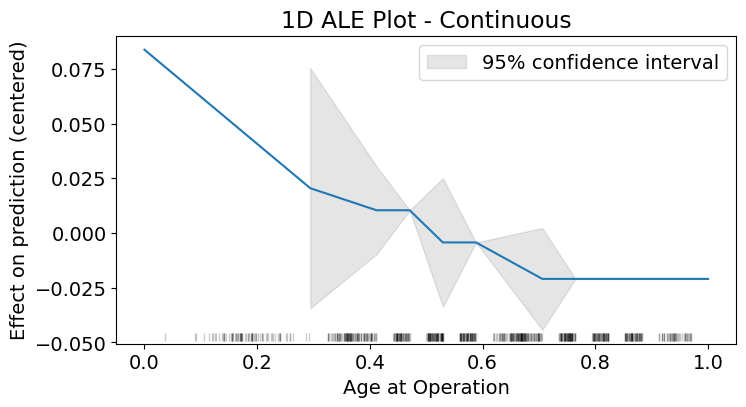

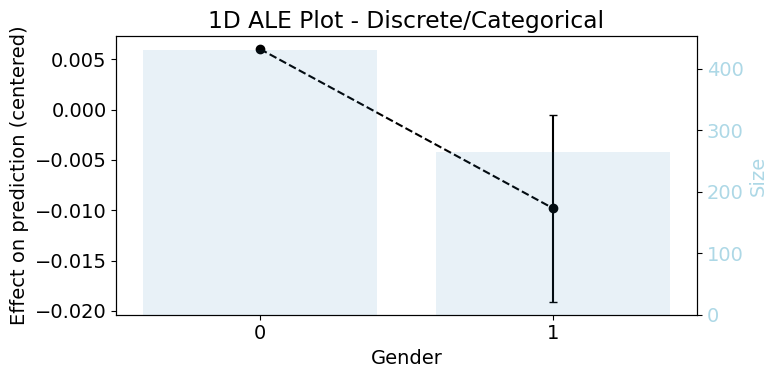

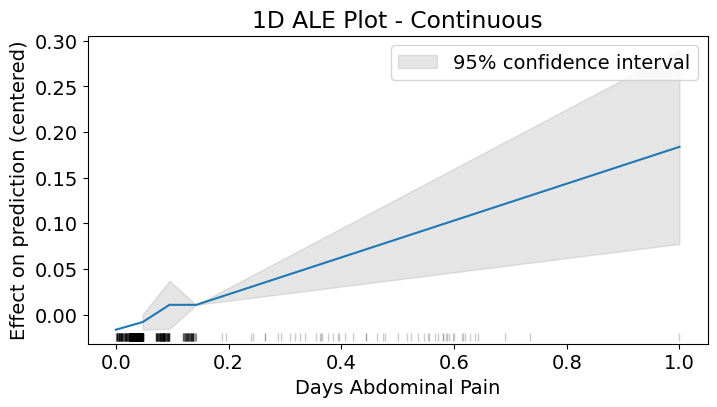

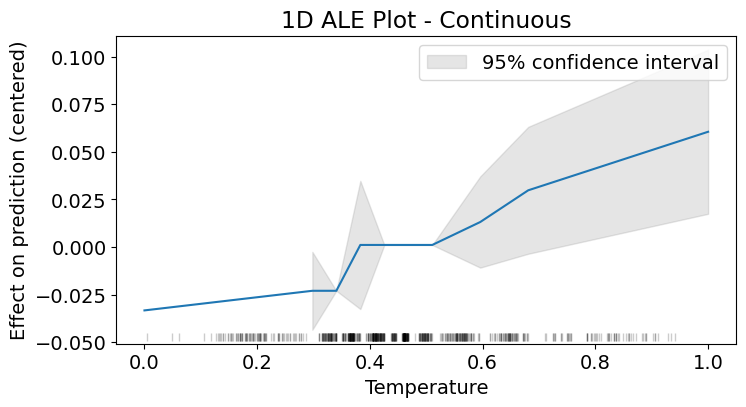

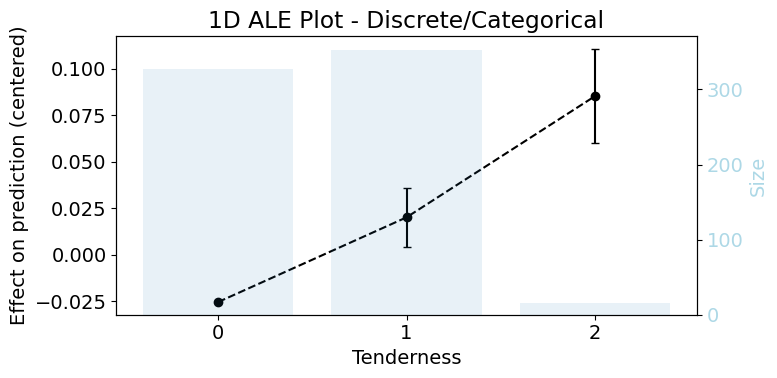

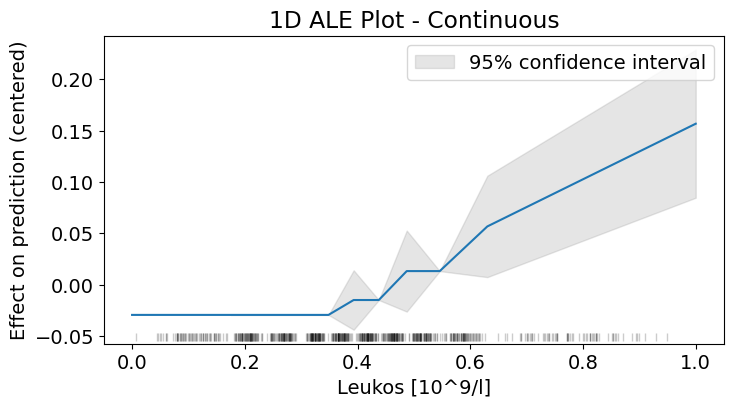

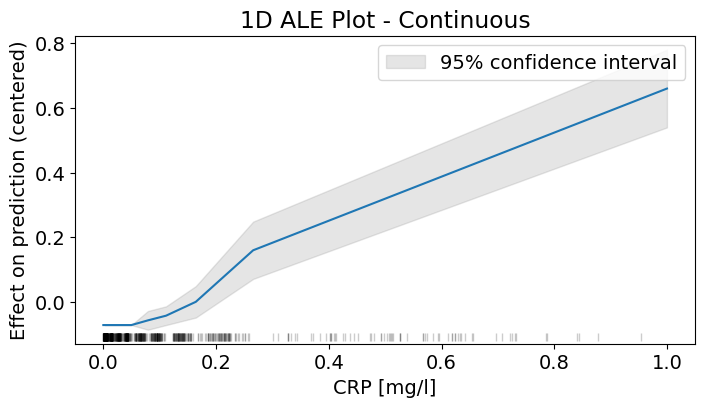

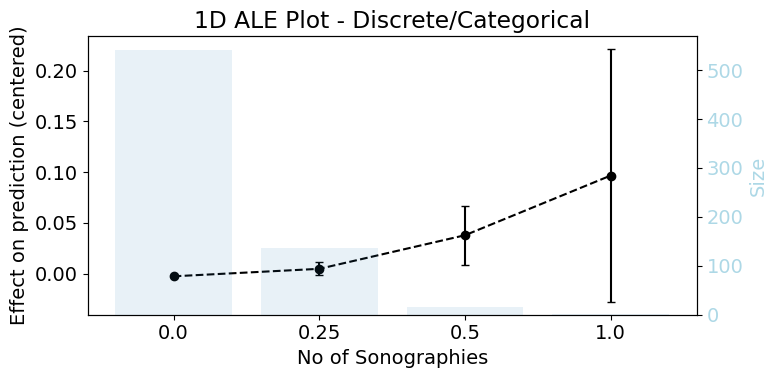

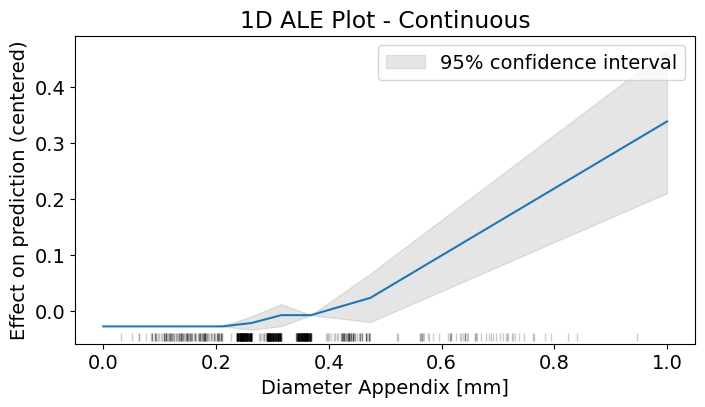

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from PyALE import ale

df = pd.read_csv(folder + '/data_norm.csv').iloc[:, :-1]

for i, f in enumerate(df.columns.to_list()):
    plt.figure(figsize=(30, 13))
    ale_eff = ale(
        X=df,
        model=model,
        feature=[f],
        grid_size=10,
        include_CI=True
    )

    plt.savefig('tmp.png')


In [ ]:
import shap

shap_explainer = shap.KernelExplainer(mlp.trained_model, X_train.iloc[:100])
shap_values = shap_explainer.shap_values(X_test.iloc[[0]], check_additivity=False)
shap.summary_plot(shap_values, X_test.iloc[[0]])

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def custom_scoring(est, X, y_true):
    y_pred = np.argmax(est.predict(X), axis=1)
    return accuracy_score(y_true.to_numpy(), y_pred)

if is_model_nn:
    results = permutation_importance(mlp.trained_model, X_train, y_train, n_repeats=10, random_state=42, scoring=custom_scoring)
else:
    results = permutation_importance(mlp.trained_model, X_train, y_train, n_repeats=10, random_state=42)

importance = results.importances_mean

for i, v in enumerate(importance):
    print(f'Feature {i}: {v:.5f}')

plt.bar(X_test.columns, importance)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

18/18 [==============================] - 0s 3ms/step


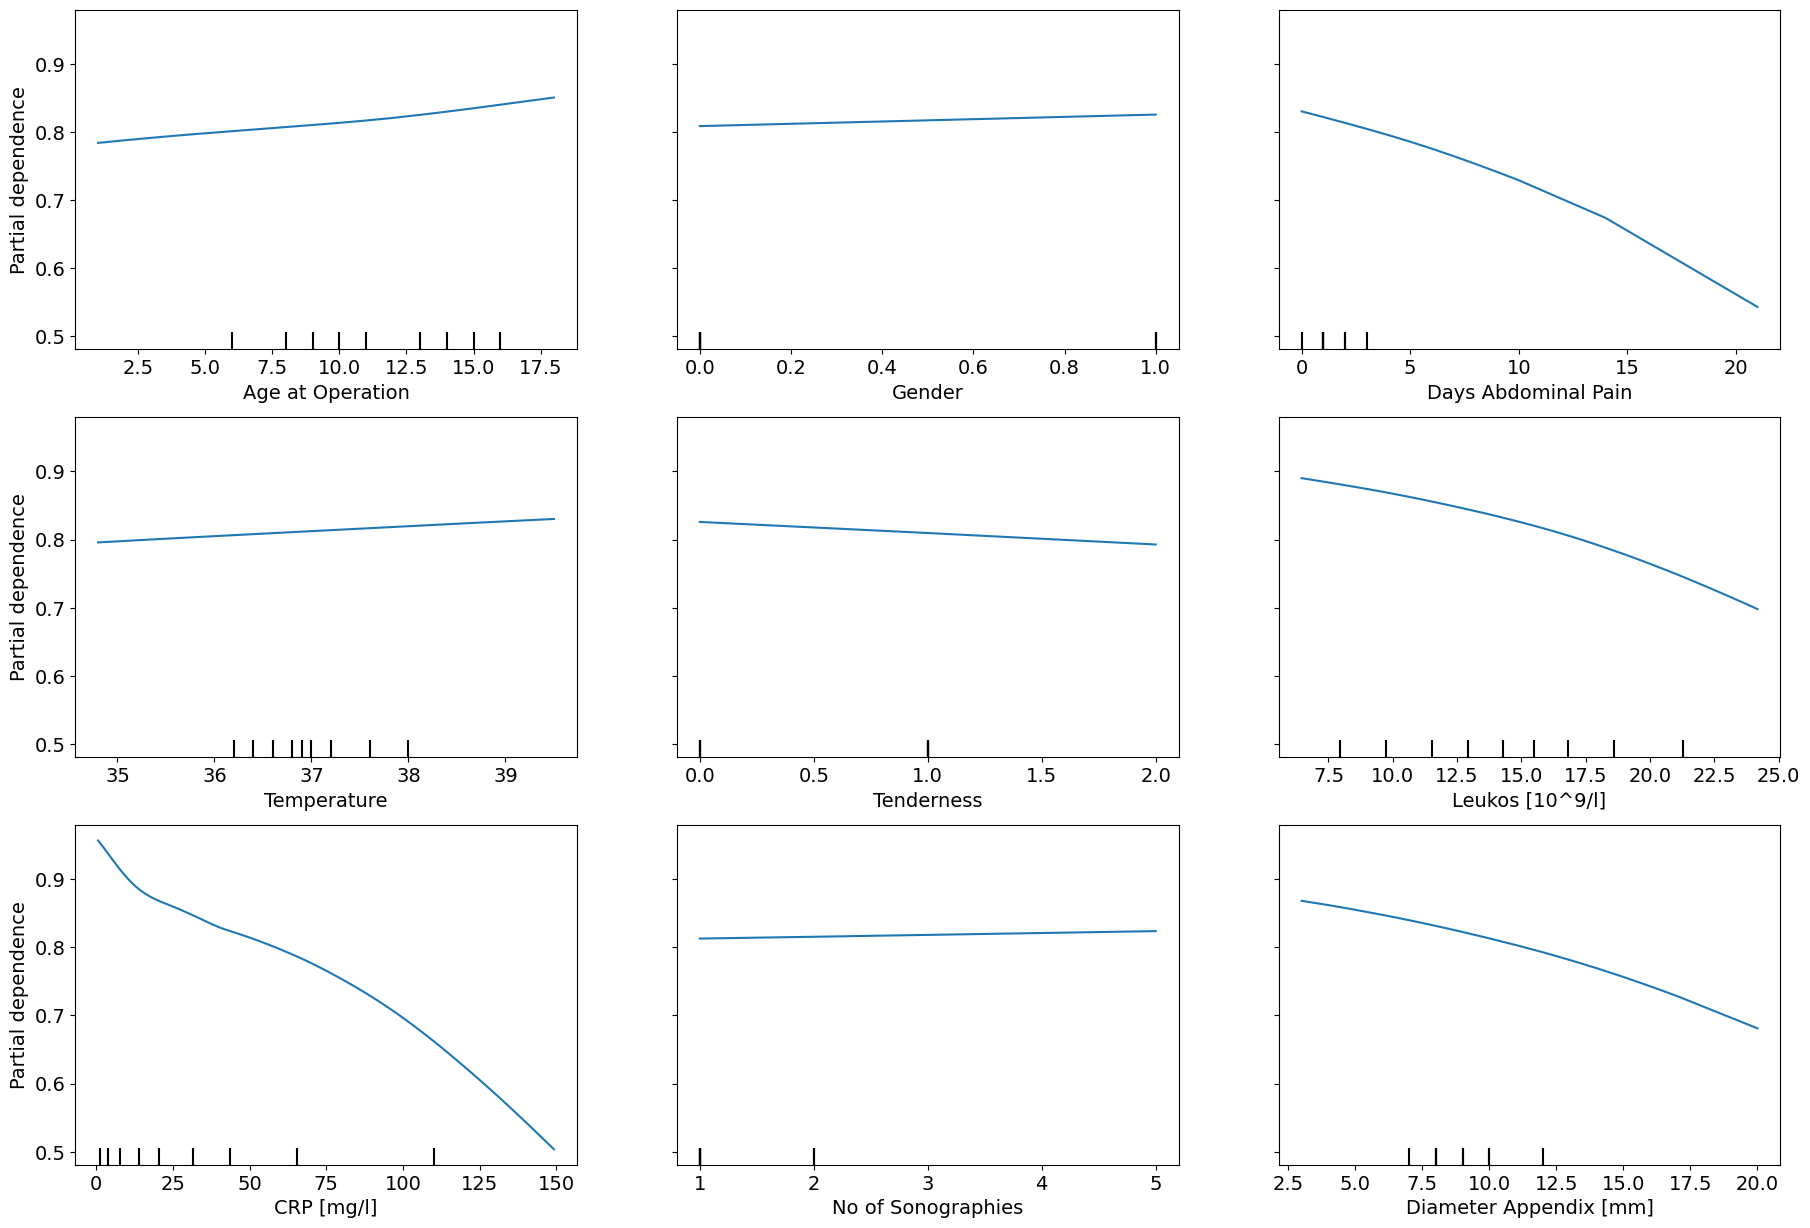

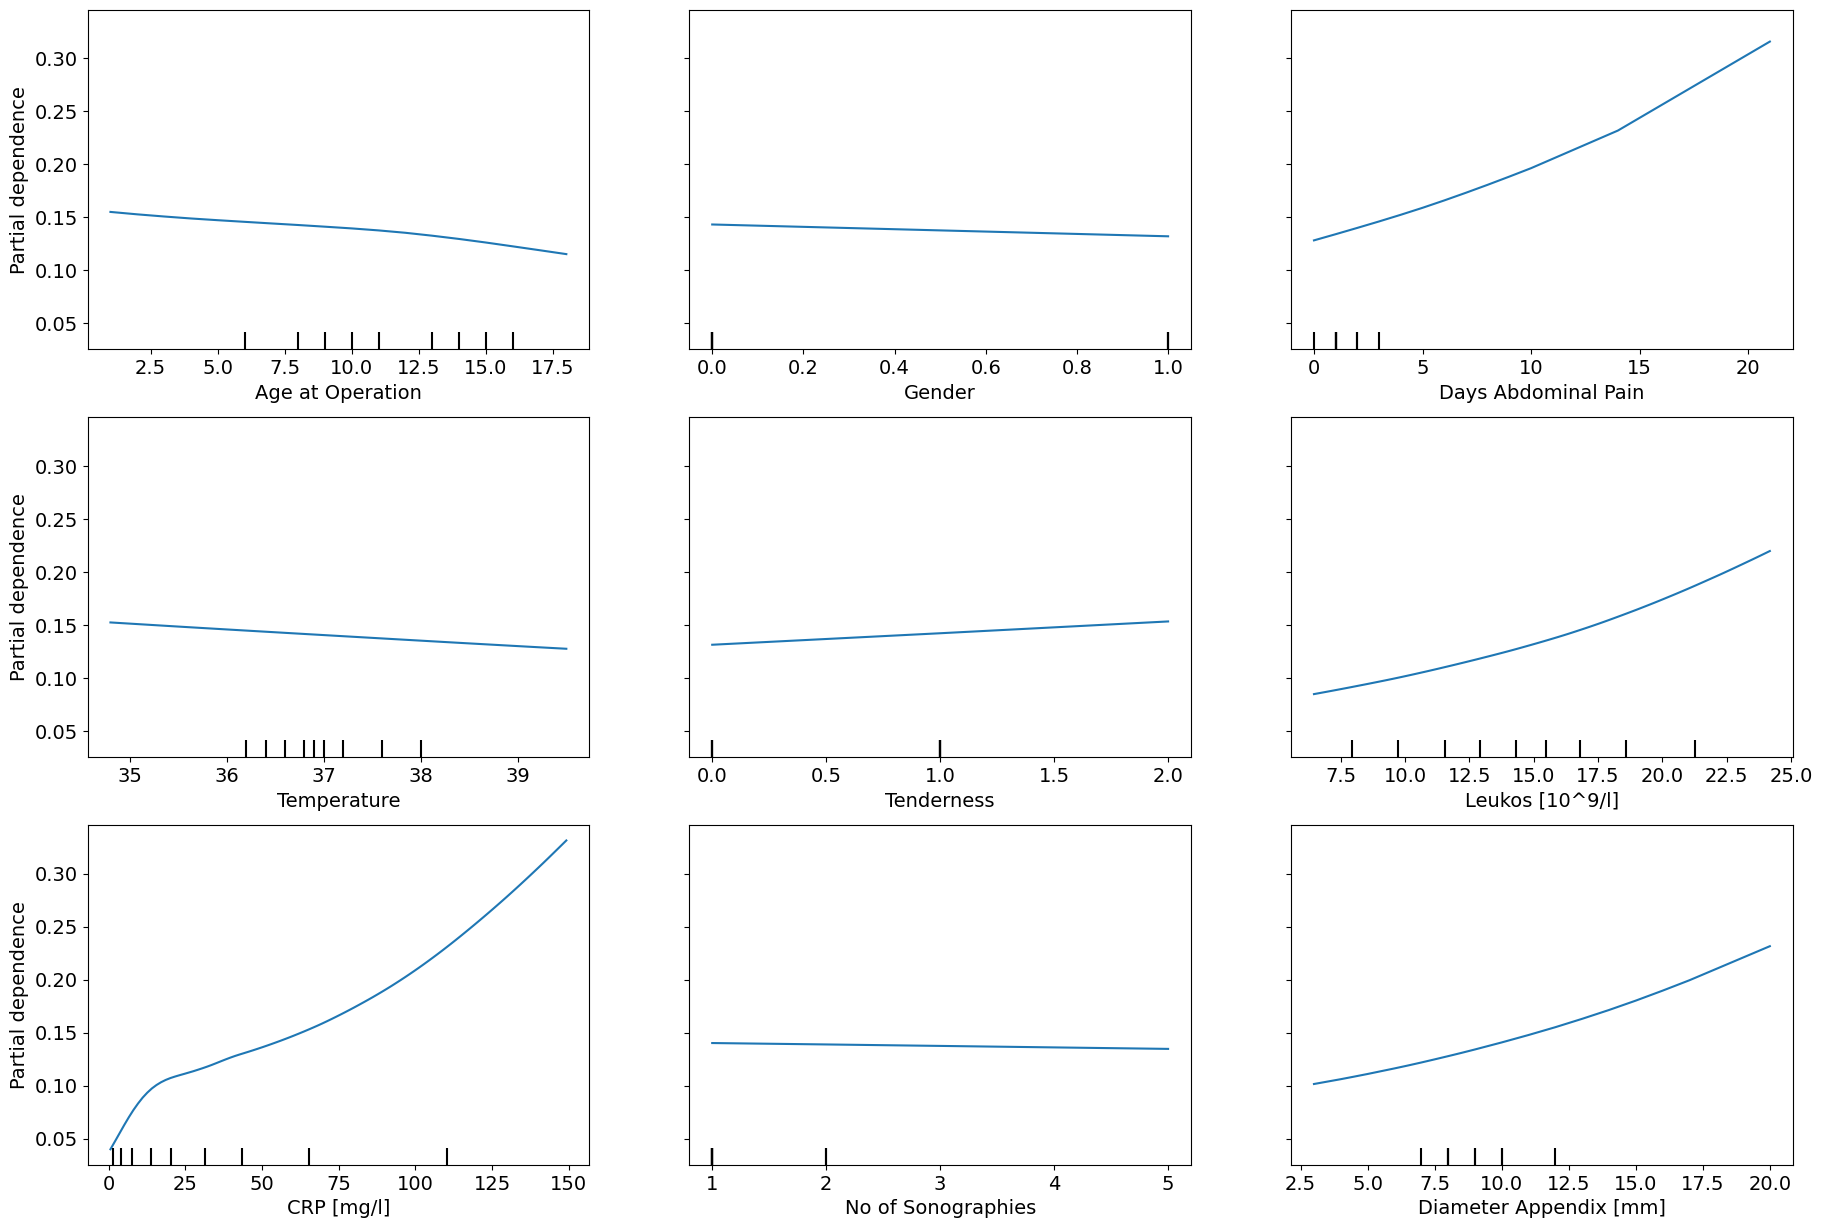

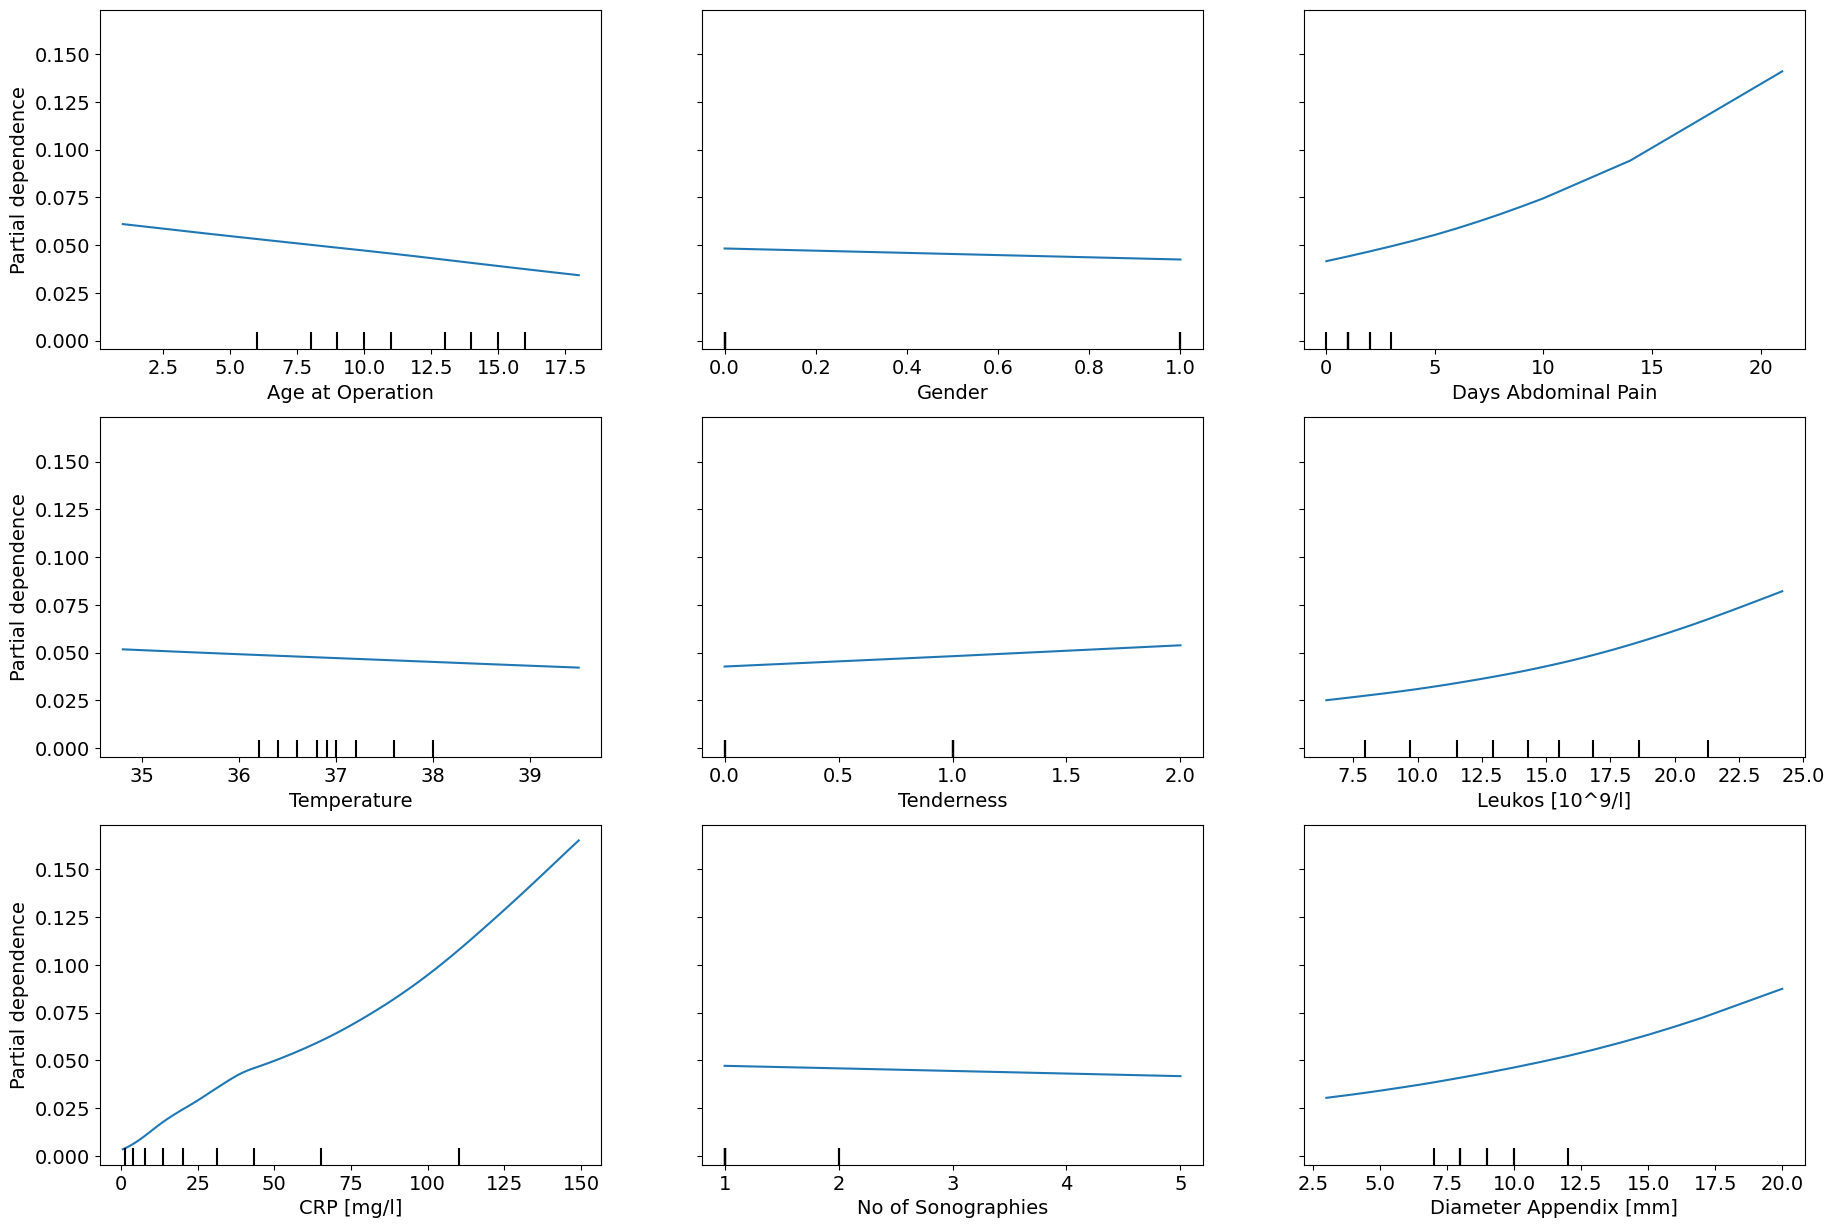

In [33]:
from sklearn.inspection import PartialDependenceDisplay

for c in y_train.unique():
    fig, ax = plt.subplots(figsize=(22, 15))
    pdp = PartialDependenceDisplay.from_estimator(mlp, X_train, features=[i for i in range(len(X_train.columns))], target=c, method='brute', ax=ax)